In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import pandas as pd
import time
from numpy import linalg as LA
import pickle
import ray

In [3]:
from Utility_fun import cart2sph, sph2cart
from pyscms.EucSCMS import KDE, SCMSLog
from pyscms.DirSCMS import DirKDE, DirSCMSLog

In [4]:
def Cir_Sph_samp(N, lat_c=60, lon_range=[0,180], sigma=0.01, pv_ax=np.array([0,0,1])):
    '''
    Generating data points from a circle on the unit sphere with additive Gaussian 
    noises to their Cartesian coordinates plus L2 normalizations
    
    Parameters:
        N: int
            The number of randomly generated data points.
            
        lat_c: float (range: 0-90)
            The latitude of the circle with respect to the pivotal axis.
            
        sigma: float
            The standard deviation of Gaussian noises.
    
        pv_ax: (3,)-array
            The pivotal axis of the circle on the sphere from which the data 
            points are generated (plus noises).
            
    Return:
        pts_c_noise: (N,3)-array
            The Cartesian coordinates of N simulated data points.
    
    '''
    ## Random longitudes with range (0, 180)
    lon_c = np.random.rand(N,)*(lon_range[1]-lon_range[0]) + lon_range[0]
    lat_c = np.ones((N,))*lat_c
    x_c, y_c, z_c = sph2cart(lon_c, lat_c)

    pts_c = np.concatenate((x_c.reshape(len(x_c), 1), 
                            y_c.reshape(len(y_c), 1),
                            z_c.reshape(len(z_c), 1)), axis=1)
    ## Add Gaussian noises
    pts_c_noise = pts_c + sigma * np.random.randn(pts_c.shape[0], pts_c.shape[1])
    ## Standardize the noisy points
    pts_c_noise = pts_c_noise/np.sqrt(np.sum(pts_c_noise**2, axis=1)).reshape(N,1)
    
    ## Rotate the data samples accordingly
    mu_c = np.array([[0,0,1]])
    R = 2*np.dot(pv_ax.reshape(3,1)+mu_c.T, pv_ax.reshape(1,3)+mu_c)/\
        np.sum((mu_c+pv_ax.reshape(1,3))**2, axis=1) - np.identity(3)
    pts_c_noise = np.dot(R, pts_c_noise.T).T
    return pts_c_noise

The current bandwidth is 0.1373045697892253.

The current bandwidth is 0.1373045697892253.



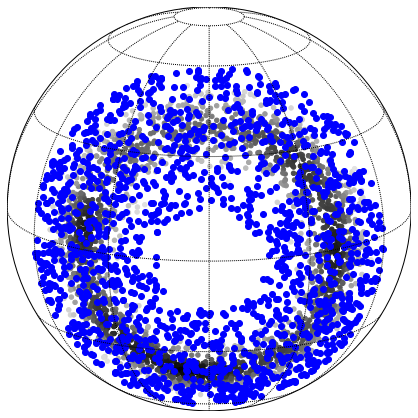

In [5]:
np.random.seed(123)  # Set an arbitrary seed for reproducibility
# Sampling the points on a circle that crosses through the north and south poles
cir_samp = Cir_Sph_samp(2000, lat_c=50, lon_range=[-180,180], sigma=0.1, pv_ax=np.array([1,0,0]))

true_cur = Cir_Sph_samp(2000, lat_c=50, lon_range=[-180,180], sigma=0, pv_ax=np.array([1,0,0]))

d_hat_dat = DirKDE(cir_samp, cir_samp, h=None)

def unif_mesh(N, lat_l=30, lat_h=90, ct_ax=np.array([1,0,0])):
    mesh_pts = np.random.multivariate_normal(mean=[0,0,0], cov=np.eye(3), 
                                             size=2*N)
    mesh_pts = mesh_pts/LA.norm(mesh_pts, axis=1).reshape(-1,1)
    mesh_pts = mesh_pts[(np.dot(mesh_pts, ct_ax) >= np.cos((90-lat_l)/180*np.pi)) & \
                        (np.dot(mesh_pts, ct_ax) <= np.cos((90-lat_h)/180*np.pi))]
    while mesh_pts.shape[0] < N:
        m_pt = np.random.multivariate_normal(mean=[0,0,0], cov=np.eye(3), 
                                             size=2*N)
        m_pt = m_pt/LA.norm(m_pt, axis=1).reshape(-1,1)
        mesh_pts = np.concatenate([mesh_pts, m_pt[(np.dot(m_pt, ct_ax) >= np.cos((90-lat_l)/180*np.pi)) & \
                        (np.dot(m_pt, ct_ax) <= np.cos((90-lat_h)/180*np.pi))]], axis=0)
    return mesh_pts[:N,:]

mesh_pts = unif_mesh(1500, lat_l=30, lat_h=75, ct_ax=np.array([1,0,0]))

nrows, ncols = (90, 180)
lon, lat = np.meshgrid(np.linspace(-180, 180, ncols), 
                       np.linspace(-90, 90, nrows))
xg, yg, zg = sph2cart(lon, lat)
query_points = np.concatenate((xg.reshape(nrows*ncols, 1), 
                               yg.reshape(nrows*ncols, 1),
                               zg.reshape(nrows*ncols, 1)), axis=1)
d_hat_Dir = DirKDE(query_points, cir_samp, h=None).reshape(nrows, ncols)

plt.rcParams.update({'font.size': 13})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(6,6))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_m, lat_m, r = cart2sph(*mesh_pts.T)
# Set up map projection
m1 = Basemap(projection='ortho', lat_0=15, lon_0=0)
# m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
#                  llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon, lat)
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_m, y_m = m1(lon_m, lat_m)
# Contour plots over the map.
# cs = m1.contour(x, y, d_hat_Dir)
cs = m1.scatter(x_p, y_p, c=1/np.log(d_hat_dat), s=20, cmap='gray')
cs = m1.scatter(x_m, y_m, color='blue')
# cs = m1.scatter(x_t, y_t, color='red', s=20, alpha=1, label='True filaments')
fig.tight_layout()
plt.show()

In [6]:
SCMS_Dir_log = DirSCMSLog(mesh_pts, cir_samp, d=1, h=None, eps=1e-7, max_iter=7000)
Dir_ridge_log = SCMS_Dir_log[:,:,SCMS_Dir_log.shape[2]-1]

The current bandwidth is 0.1373045697892253.

The directional SCMS algorithm converges in 24steps!


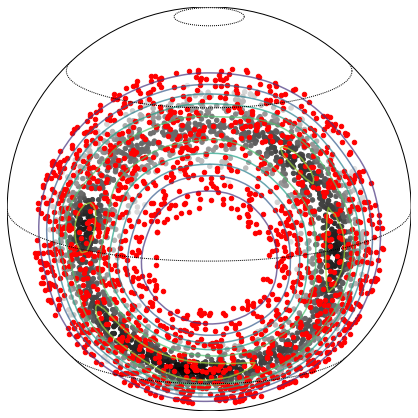

In [13]:
plt.rcParams.update({'font.size': 13})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(6,6))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_r, lat_r, r = cart2sph(*SCMS_Dir_log[:,:,0].T)
# Set up map projection
m1 = Basemap(projection='ortho', lat_0=15, lon_0=0)
# m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
#                  llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
# m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 45))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon, lat)
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_r, y_r = m1(lon_r, lat_r)
# Contour plots over the map.
cs = m1.contour(x, y, d_hat_Dir, alpha=0.7, linewidths=1.5)
cs = m1.scatter(x_p, y_p, c=2/np.log(d_hat_dat), s=20, cmap='gray')
# cs = m1.scatter(x_m, y_m, color='blue')
cs = m1.scatter(x_r, y_r, color='red', s=20, alpha=1)
fig.tight_layout()
plt.savefig('./Figures/DirSCMS_step0.pdf')

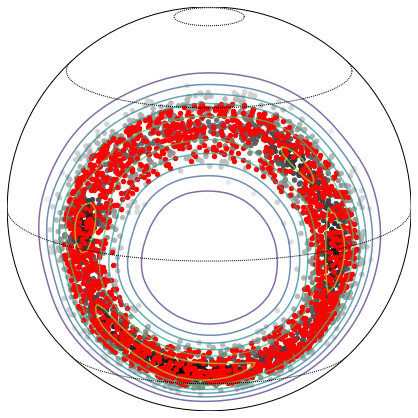

In [14]:
fig = plt.figure(figsize=(6,6))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_r, lat_r, r = cart2sph(*SCMS_Dir_log[:,:,1].T)
# Set up map projection
m1 = Basemap(projection='ortho', lat_0=15, lon_0=0)
# m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
#                  llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
# m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 45))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon, lat)
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_r, y_r = m1(lon_r, lat_r)
# Contour plots over the map.
cs = m1.contour(x, y, d_hat_Dir, alpha=0.7, linewidths=1.5)
cs = m1.scatter(x_p, y_p, c=2/np.log(d_hat_dat), s=20, cmap='gray')
# cs = m1.scatter(x_m, y_m, color='blue')
cs = m1.scatter(x_r, y_r, color='red', s=20, alpha=1)
fig.tight_layout()
plt.savefig('./Figures/DirSCMS_step1.pdf')

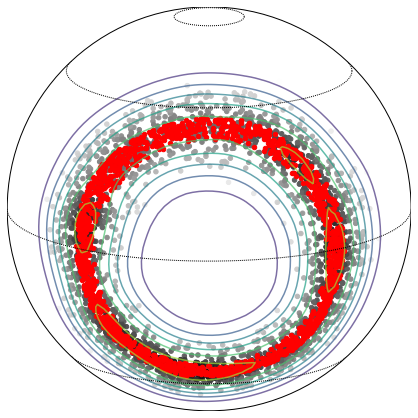

In [15]:
fig = plt.figure(figsize=(6,6))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_r, lat_r, r = cart2sph(*SCMS_Dir_log[:,:,2].T)
# Set up map projection
m1 = Basemap(projection='ortho', lat_0=15, lon_0=0)
# m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
#                  llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
# m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 45))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon, lat)
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_r, y_r = m1(lon_r, lat_r)
# Contour plots over the map.
cs = m1.contour(x, y, d_hat_Dir, alpha=0.7, linewidths=1.5)
cs = m1.scatter(x_p, y_p, c=2/np.log(d_hat_dat), s=20, cmap='gray')
# cs = m1.scatter(x_m, y_m, color='blue')
cs = m1.scatter(x_r, y_r, color='red', s=20, alpha=1)
fig.tight_layout()
plt.savefig('./Figures/DirSCMS_step2.pdf')

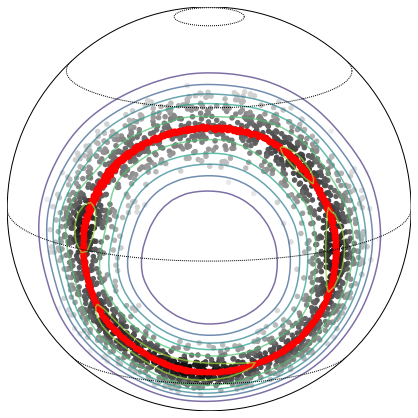

In [16]:
fig = plt.figure(figsize=(6,6))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_r, lat_r, r = cart2sph(*SCMS_Dir_log[:,:,4].T)
# Set up map projection
m1 = Basemap(projection='ortho', lat_0=15, lon_0=0)
# m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
#                  llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
# m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 45))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon, lat)
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_r, y_r = m1(lon_r, lat_r)
# Contour plots over the map.
cs = m1.contour(x, y, d_hat_Dir, alpha=0.7, linewidths=1.5)
cs = m1.scatter(x_p, y_p, c=2/np.log(d_hat_dat), s=20, cmap='gray')
# cs = m1.scatter(x_m, y_m, color='blue')
cs = m1.scatter(x_r, y_r, color='red', s=20, alpha=1)
fig.tight_layout()
plt.savefig('./Figures/DirSCMS_step4.pdf')

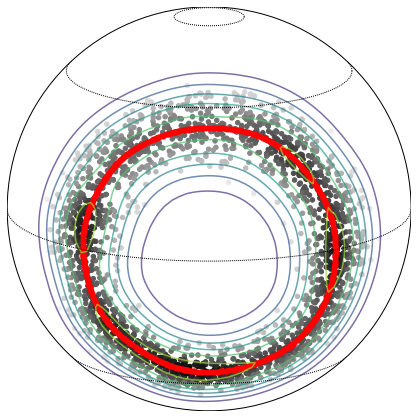

In [17]:
fig = plt.figure(figsize=(6,6))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_r, lat_r, r = cart2sph(*SCMS_Dir_log[:,:,8].T)
# Set up map projection
m1 = Basemap(projection='ortho', lat_0=15, lon_0=0)
# m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
#                  llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
# m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 45))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon, lat)
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_r, y_r = m1(lon_r, lat_r)
# Contour plots over the map.
cs = m1.contour(x, y, d_hat_Dir, alpha=0.7, linewidths=1.5)
cs = m1.scatter(x_p, y_p, c=2/np.log(d_hat_dat), s=20, cmap='gray')
# cs = m1.scatter(x_m, y_m, color='blue')
cs = m1.scatter(x_r, y_r, color='red', s=20, alpha=1)
fig.tight_layout()
plt.savefig('./Figures/DirSCMS_step8.pdf')

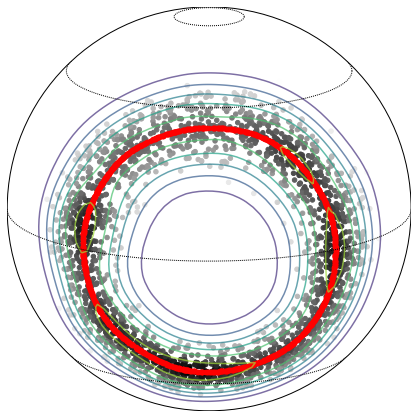

In [18]:
fig = plt.figure(figsize=(6,6))
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_r, lat_r, r = cart2sph(*SCMS_Dir_log[:,:,16].T)
# Set up map projection
m1 = Basemap(projection='ortho', lat_0=15, lon_0=0)
# m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
#                  llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
# m1.drawmeridians(np.arange(-180, 180, 90))
m1.drawparallels(np.arange(-90, 90, 45))
# Compute native map projection coordinates of lat/lon grid.
x, y = m1(lon, lat)
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_r, y_r = m1(lon_r, lat_r)
# Contour plots over the map.
cs = m1.contour(x, y, d_hat_Dir, alpha=0.7, linewidths=1.5)
cs = m1.scatter(x_p, y_p, c=2/np.log(d_hat_dat), s=20, cmap='gray')
# cs = m1.scatter(x_m, y_m, color='blue')
cs = m1.scatter(x_r, y_r, color='red', s=20, alpha=1)
fig.tight_layout()
plt.savefig('./Figures/DirSCMS_step16.pdf')